In [1]:
from logger import Logger
import utils
import pandas as pd
from importlib import reload
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

import countminsketch
from tqdm import tqdm

reload(countminsketch)
reload(utils)

reload(mpl); reload(plt);




In [2]:
logger = Logger(show = True, html_output = True, config_file = "config.txt")

2019.06.26-17:33:51 Initialize the logger
2019.06.26-17:33:51 Create logs folder logs
2019.06.26-17:33:51 Create log file logs/2019-06-26_17_33_51_log0.html
2019.06.26-17:33:51 Create models folder models
2019.06.26-17:33:51 Create output folder output
2019.06.26-17:33:51 Create data folder data
2019.06.26-17:33:51 Read config file config.txt


In [3]:
df = utils.load_data("DATA_FILE1", logger)



[2019.06.26-17:33:51] Start loading data from capture20110816.pcap.netflow.labeled...
[2019.06.26-17:33:52] Line 100000: ['2011-08-16 10:08:32.395', '4.484', 'TCP', '147.32.85.26', '56220', '209.85.149.132', '443', 'FSPA_', '0', '20', '4228', '1', 'LEGITIMATE']
[2019.06.26-17:33:53] Line 200000: ['2011-08-16 10:15:13.826', '0.000', 'UDP', '147.32.80.9', '53', '147.32.85.7', '43077', 'INT', '0', '1', '500', '1', 'Background']
[2019.06.26-17:33:54] Line 300000: ['2011-08-16 10:21:41.580', '0.000', 'UDP', '147.32.84.229', '13363', '82.144.199.176', '30584', 'INT', '0', '1', '621', '1', 'Background']
[2019.06.26-17:33:54] Line 400000: ['2011-08-16 10:28:42.284', '3.581', 'UDP', '95.55.135.150', '47583', '147.32.84.229', '13363', 'INT', '0', '3', '264', '1', 'Background']
[2019.06.26-17:33:55] Line 500000: ['2011-08-16 10:34:47.745', '0.000', 'TCP', '205.188.11.81', '443', '147.32.86.171', '1056', 'A_', '0', '1', '60', '1', 'Background']
[2019.06.26-17:33:56] Line 600000: ['2011-08-16 10:39

In [4]:
df = df[df.label != "Background"]
infected_host_ip = logger.config_dict['INFECTED_HOST1']
df_host = df[(df['ip_src'] == infected_host_ip) | (df['ip_dest'] == infected_host_ip)]

In [5]:
df_host.head()

,date,duration,protocol,ip_src,port_src,ip_dest,port_dest,flags,tos,packets,bytes,flows,label
6099,2011-08-16 10:02:08.703,0.000,UDP,147.32.84.165,1025,147.32.80.9,53,INT,0,1,78,1,Botnet
6153,2011-08-16 10:02:08.871,0.000,UDP,147.32.80.9,53,147.32.84.165,1025,INT,0,1,427,1,Botnet
6154,2011-08-16 10:02:08.872,0.128,TCP,147.32.84.165,1039,195.113.232.73,80,SPA_,0,6,471,1,Botnet
6155,2011-08-16 10:02:08.873,0.001,TCP,195.113.232.73,80,147.32.84.165,1039,SPA_,0,6,4907,1,Botnet
33366,2011-08-16 10:03:53.343,0.000,TCP,147.32.96.45,2092,147.32.84.165,21,S_,0,1,74,1,Botnet


In [6]:

ips = utils.extract_other(df_host, infected_host_ip)


In [7]:
true_cnt = utils.true_count(ips)

In [8]:
unique_ips = set(ips.values)
print("A total of %d ips with %d unique" % (len(ips) ,len(unique_ips)))

assert (len(true_cnt)==len(unique_ips))

A total of 5877 ips with 1582 unique


First let's try computing the width and depth using the erors

In [9]:
results=[]
width = []
depth = []

epsilon =  [0.00001, 0.0001, 0.001, 0.01]
delta = [0.00001,0.0001, 0.001, 0.01]

scores = np.full([len(epsilon), len(delta)], 0)

for i, e in enumerate(epsilon):
    for j, d in enumerate(delta):
        
        c = countminsketch.CountMinSketch.init_by_error(e, d)
        
        c.add_all(ips.values)
        
        top = c.extract_top(unique_ips)
        
        score = utils.get_estimation_error(true_cnt, top, 10)
        
        results.append({'top': top[:10], 'delta': d, 'epsilon': e, 
                        'score': score, 'width': c.width, 'depth': c.depth})
        
        scores[i][j] = score
        
        width.append(c.width)
        depth.append(c.depth)

In [10]:
results.sort(key=itemgetter('score'))

In [11]:
results

[{'top': [['91.212.135.158', 404.0],
   ['64.59.134.8', 194.0],
   ['24.71.223.11', 160.0],
   ['216.32.180.22', 154.0],
   ['90.177.113.3', 100.0],
   ['147.32.96.45', 100.0],
   ['65.55.37.72', 96.0],
   ['65.55.37.88', 94.0],
   ['65.55.92.136', 93.0],
   ['65.55.92.168', 90.0]],
  'delta': 1e-05,
  'epsilon': 1e-05,
  'score': 0.0,
  'width': 271828,
  'depth': 12},
 {'top': [['91.212.135.158', 404.0],
   ['64.59.134.8', 194.0],
   ['24.71.223.11', 160.0],
   ['216.32.180.22', 154.0],
   ['90.177.113.3', 100.0],
   ['147.32.96.45', 100.0],
   ['65.55.37.72', 96.0],
   ['65.55.37.88', 94.0],
   ['65.55.92.136', 93.0],
   ['65.55.92.168', 90.0]],
  'delta': 0.0001,
  'epsilon': 1e-05,
  'score': 0.0,
  'width': 271828,
  'depth': 9},
 {'top': [['91.212.135.158', 404.0],
   ['64.59.134.8', 194.0],
   ['24.71.223.11', 160.0],
   ['216.32.180.22', 154.0],
   ['90.177.113.3', 100.0],
   ['147.32.96.45', 100.0],
   ['65.55.37.72', 96.0],
   ['65.55.37.88', 94.0],
   ['65.55.92.136', 93.0]

In [12]:
true_cnt
    

[('91.212.135.158', 404),
 ('64.59.134.8', 194),
 ('24.71.223.11', 160),
 ('216.32.180.22', 154),
 ('90.177.113.3', 100),
 ('147.32.96.45', 100),
 ('65.55.37.72', 96),
 ('65.55.37.88', 94),
 ('65.55.92.136', 93),
 ('65.55.92.168', 90),
 ('65.55.92.152', 90),
 ('65.54.188.72', 89),
 ('202.108.252.141', 89),
 ('74.205.4.13', 88),
 ('65.55.37.120', 87),
 ('65.55.37.104', 82),
 ('65.55.92.184', 81),
 ('206.46.232.11', 81),
 ('65.54.188.110', 78),
 ('65.54.188.94', 76),
 ('65.54.188.126', 74),
 ('72.14.213.27', 62),
 ('64.98.36.4', 59),
 ('147.32.80.9', 58),
 ('65.55.88.22', 55),
 ('216.163.188.54', 53),
 ('38.113.116.213', 49),
 ('216.32.181.178', 48),
 ('74.125.67.27', 38),
 ('213.199.180.150', 38),
 ('74.125.113.27', 37),
 ('74.125.39.27', 32),
 ('213.165.64.100', 31),
 ('74.125.47.27', 30),
 ('195.50.106.142', 30),
 ('213.165.64.102', 29),
 ('200.142.128.100', 29),
 ('200.142.128.51', 28),
 ('94.245.120.86', 26),
 ('216.33.127.20', 26),
 ('64.136.44.37', 25),
 ('74.125.43.27', 24),
 ('6

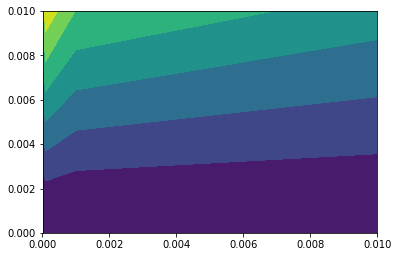

In [13]:
plt.contourf(epsilon, delta, scores)


Apparently this is not much use and the space requirement is huge. Let's try a grid-search

In [14]:
width = list(set(width))
depth = list(set(depth))
# try a plain grid search
unique_nr = len(unique_ips)
max = unique_nr*2
width1 = [int(i) for i in np.linspace(20, unique_nr, 30)] + [int(i) for i in np.linspace(unique_nr+1, max, 10)]
depth1 = [int(i) for i in np.linspace(5, 12, 5)]
scores = np.full([len(depth1), len(width1)], 0)

results=[]

for i, d in tqdm(enumerate(depth1)):

    for j, w in enumerate(width1):
        c = countminsketch.CountMinSketch(w, d)
        
        c.add_all(ips.values)
        
        top = c.extract_top(unique_ips)
        
        score = utils.get_estimation_error(true_cnt, top, 100)
        
        results.append({'top': top[:10], 'score': score, 'width': c.width, 'depth': c.depth})
        
        scores[i][j] = score

5it [00:13,  2.95s/it]


In [15]:
scores


array([[3757, 2200, 1583, 1122,  758,  573,  483,  307,  253,  229,  183,
         170,  138,  131,  108,   99,   92,   78,   98,   71,   46,   56,
          44,   41,   42,   46,   39,   25,   30,   43,   40,   28,   22,
          24,   21,   32,   19,   19,   20,   19],
       [3757, 2091, 1546, 1062,  747,  581,  427,  335,  237,  193,  162,
         124,  114,  105,   89,  104,   59,   66,   54,   56,   62,   51,
          41,   21,   30,   35,   43,   35,   21,   22,   32,   32,   18,
          19,   20,   20,   18,   18,   19,   18],
       [3757, 2282, 1495,  939,  669,  518,  382,  236,  188,  138,  141,
         122,   82,   96,   71,   68,   51,   49,   52,   36,   32,   22,
          35,   21,   37,   17,   22,   23,   19,   21,   21,   21,   20,
          19,   19,   18,   18,   18,   18,   18],
       [3757, 2097, 1381,  925,  635,  457,  304,  222,  171,  140,  118,
          95,   76,   71,   44,   63,   52,   38,   27,   21,   25,   20,
          26,   26,   20,   20,  

We notice the error decreases faster with width than with depth, keep in mind that
the space requirement of depth is much bigger

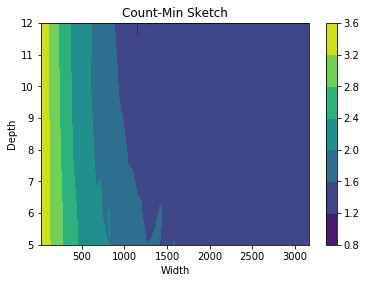

In [16]:

plt.contourf(width1, depth1, np.log10(scores))
plt.title("Count-Min Sketch")
plt.xlabel("Width")
plt.ylabel("Depth")
plt.colorbar()
plt.savefig("./output/count-min.eps", format='eps', dpi=1000)


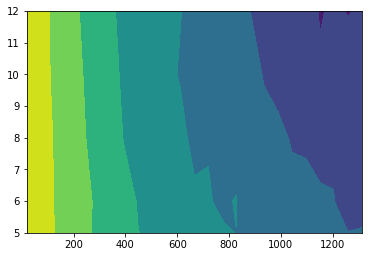

In [17]:
# looks like we can zoom in
plt.contourf(width1[:25], depth1, np.log10([i[:25] for i in scores]))


Lets try and analyse a smaller depth

In [18]:
unique_nr = len(unique_ips)
max = unique_nr*2.5
width1 = [int(i) for i in np.linspace(20, unique_nr, 30)] + [int(i) for i in np.linspace(unique_nr+1, max, 10)]
depth1 = range(2,10)
scores = np.full([len(depth1), len(width1)], 0)

len(depth1), len(width1), len(scores), len(scores[0]), depth1
results=[]
space = np.full([len(depth1), len(width1)], 0)

for i, d in tqdm(enumerate(depth1)):

    for j, w in enumerate(width1):
        c = countminsketch.CountMinSketch(w, d)
        
        c.add_all(ips.values)
        
        top = c.extract_top(unique_ips)
        
        score = utils.get_estimation_error(true_cnt, top, 10)
        
        results.append({'top': top[:10], 'score': score, 'width': c.width, 'depth': c.depth})
        
        scores[i][j] = score
        space[i][j] = w * d

8it [00:15,  2.30s/it]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


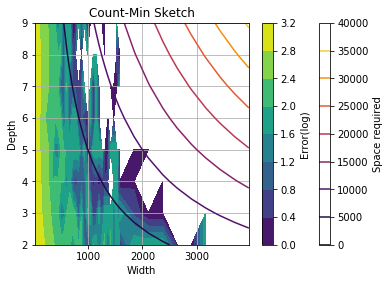

In [19]:
plt.contour(width1, depth1, space, cmap='inferno')
c = plt.colorbar()
c.set_label("Space required")
plt.contourf(width1, depth1, np.log10(scores))
c = plt.colorbar()
c.set_label("Error(log)")
plt.grid(True)
plt.title("Count-Min Sketch")
plt.xlabel("Width")
plt.ylabel("Depth")
plt.savefig("./output/count-min-space-requirement.eps", format='eps', dpi=1000)

This is perfect. We can notice that a small `depth` with a big `width` is much more efficient space wise.
If we compare to the Reservoir sampling we notice that we require much more space to reach an error of 0, but
this is because the data-set is quite small and it can fit without any problems in a Reservoir or 5000.

Now let's try a comparison with the Frequent with a limited memory size

In [21]:
tries = [[250, 2], [167, 3], [500,2], [333,3], [2500, 2]]
for [w,d] in tries:
    result = 0
    for _tries in range(50):
    
        c = countminsketch.CountMinSketch(w, d)
                
        c.add_all(ips.values)
        
        top = c.extract_top(unique_ips)
        
        score = utils.get_estimation_error(true_cnt, top, 10)
        
        result += score
        
    print("For size %f we got %f" % (w*d, result/50))

For size 500.000000 we got 549.180000
For size 501.000000 we got 531.480000
For size 1000.000000 we got 182.300000
For size 999.000000 we got 198.820000
For size 5000.000000 we got 31.840000
